# Chapter 10: Video, GIS and Preferences

Accompanying code for the book [The Art of Feature Engineering](http://artoffeatureengineering.com).

This notebook plus notebooks for the other chapters are available online at https://github.com/DrDub/artfeateng


## MIT License

Copyright 2019 Pablo Duboue

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Limitations

* Simple python intented for people coming from other languages that plan to use the ideas described in the book outside of Python.
* Many of these techniques are available as library calls. They are spelled out as for teaching purposes.
* Resource limitations:
 * At most one day of running time per notebook.
 * No GPU required.
 * Minimal dependencies.
 * At most 8Gb of RAM. **Preferences uses more than 8Gb of RAM.**
* Due to resource limitations, these notebooks do not undergo as much hyperparameter tuning as necessary. This is a shortcoming of these case studies, keep it in mind if you want to follow a similar path with your experiments.
* To help readers try variants of some cells in isolation, the cells are easily executable without having to re-run the whole notebook. As such, most cells read everything they need from disk and write all their results back into disk, which is unnecessary with normal notebooks. The code for each cell might look long and somewhat unusual. In a sense, each cell tries to be a separate Python program.
* I dislike Pandas so these notebooks are Pandas-free, which might seem unusual to some.

# Video

For video data, we'll look into the problem of key frame detection and blob tracking.

## Key Frame Detection

Using the 45 key frames marked in the video by hand. Let us see if we can train a simple classifier to tell whether two contiguous frames are supposed to be a key frame transition (Cell #11).

In [1]:
# CELL 11
import numpy as np
import cv2

PARAM_WINDOW_SIZE = 3

keyframes = set(map(lambda x:int(x.strip()), open("keyframes_by_hand.txt").readlines()))

cap = cv2.VideoCapture('video.mp4')
previous_hists = [ None, ] * PARAM_WINDOW_SIZE
total_key_frames = 0
with open("ch10_cell11_key_frame_training.tsv", "w") as f:
    for frame in ['prev', 'current']:
        for colour in ['r', 'g', 'b']:
            for bin in range(16):
                f.write("{}-{}-{}\t".format(frame, colour, bin+1))
    f.write('is_key_frame\n')
    frame_counter = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_counter % 1000 == 0:
            print("{:,} frames processed.".format(frame_counter))
        frame_counter += 1
        
        hists = list()
        for idx in range(3):
            hist = cv2.calcHist([frame],[idx],None,[16],[0,256])
            hists.extend(hist.reshape(-1))
        if previous_hists[0] is not None:
            is_key_frame = False
            if frame_counter in keyframes:
                is_key_frame = True
                total_key_frames += 1
            f.write("\t".join(map(lambda x:str(int(x)), previous_hists[0] + hists)) + "\t" + 
                    ("1" if is_key_frame else "0") + "\n")
        previous_hists.pop(0)
        previous_hists.append(hists)
cap.release()
        
print("Total frames", frame_counter - 1)
print("Total key frames", total_key_frames)

0 frames processed.
1,000 frames processed.
2,000 frames processed.
3,000 frames processed.
4,000 frames processed.
5,000 frames processed.
6,000 frames processed.
7,000 frames processed.
8,000 frames processed.
9,000 frames processed.
Total frames 9275
Total key frames 41


With these 75 keyframes we can now train a classifier using the histograms (Cell #12).

In [2]:
# CELL 12
import numpy as np
import random

PARAM_TRAIN_SIZE = 7000  # use first 7000 frames for training
PARAM_DO_SCALING = False

data_x = list()
data_y = list()
with open("ch10_cell11_key_frame_training.tsv") as f:
    next(f)
    for line in f:
        fields = list(map(lambda x:int(float(x)),line.strip().split("\t")))
        data_x.append( fields[:-1] )
        data_y.append( fields[-1] )

x = np.array( data_x ).astype('float64')
y = np.array( data_y ).astype('float64')

xtrain = x[:PARAM_TRAIN_SIZE , :]
ytrain = y[:PARAM_TRAIN_SIZE]
xtest  = x[PARAM_TRAIN_SIZE: , :]
ytest  = y[PARAM_TRAIN_SIZE:]
x = None
y = None

if PARAM_DO_SCALING:
    xtrain_min  = xtrain.min(axis=0)
    xtrain_max  = xtrain.max(axis=0)
    # some can be zero if the column is constant in training
    xtrain_diff = xtrain_max - xtrain_min
    for idx in range(len(xtrain_diff)):
        if xtrain_diff[idx] == 0.0:
            xtrain_diff[idx] = 1.0
    xtrain_scaling = 1.0 / xtrain_diff
    xtrain -= xtrain_min; xtrain *= xtrain_scaling
    xtest  -= xtrain_min; xtest  *= xtrain_scaling


rand = random.Random(42)
shuffled = list(range(PARAM_TRAIN_SIZE))
rand.shuffle(shuffled)
xtrain_sampled = np.zeros( (2900, xtrain.shape[1]) )
ytrain_sampled = np.zeros(  2900 )
pos = 0
for idx, val in enumerate(ytrain):
    if val:
        xtrain_sampled[pos,:] = xtrain[idx,:]
        ytrain_sampled[pos]   = 1
        pos += 1
for idx in shuffled:
    if ytrain[idx] == 0:
        xtrain_sampled[pos,:] = xtrain[idx,:]
        ytrain_sampled[pos]   = 0
        pos += 1
        if pos == xtrain_sampled.shape[0]:
            break

# Train SVM poly kernel
from sklearn.svm import SVC
clf = SVC(random_state=42,kernel='poly',degree=2,gamma='auto').fit(xtrain_sampled, ytrain_sampled)

import pickle
with open("ch10_cell12_model.pk", "wb") as pkl:
    pickle.dump(clf, pkl)

from sklearn.metrics import precision_recall_fscore_support

print("Sampled", xtrain_sampled.shape[0])

print("On training")
ytrain_pred = clf.predict(xtrain)
prec, rec, f1, support = precision_recall_fscore_support(ytrain, ytrain_pred, average=None)
print("Predicted:", ytrain_pred.sum())
print("Expected: ", ytrain.sum())
print("Accuracy: ", np.dot(ytrain_pred,ytrain).sum())
print("Precision: {:2.4}".format(prec[1] * 100))
print("Recall:    {:2.4}".format(rec[1]  * 100))
print("F1:        {:2.4}".format(f1[1]   * 100))
print("Support    {}".format(support))

print("\nOn test")
ytest_pred             = clf.predict(xtest)
prec, rec, f1, support = precision_recall_fscore_support(ytest, ytest_pred, average=None)
print("Predicted:", ytest_pred.sum())
print("Expected: ", ytest.sum())
print("Accuracy: ", np.dot(ytest_pred,ytest).sum())
print("Precision: {:2.4}".format(prec[1] * 100))
print("Recall:    {:2.4}".format(rec[1]  * 100))
print("F1:        {:2.4}".format(f1[1]   * 100))
print("Support    {}".format(support))
xtrain_sampled = None

Sampled 2900
On training
Predicted: 63.0
Expected:  24.0
Accuracy:  24.0
Precision: 38.1
Recall:    100.0
F1:        55.17
Support    [6976   24]

On test
Predicted: 100.0
Expected:  17.0
Accuracy:  11.0
Precision: 11.0
Recall:    64.71
F1:        18.8
Support    [2256   17]


That's pretty poor but it is trained on only one video. Let's see how well it performs in practice (Cell #13). (Press escape key to stop the playback). The vertical line close to the left side indicates the frames was predicted as key frame. The second vertical line indicates is an actual key frame. The top horizontal line indicates the testing segment of the video.

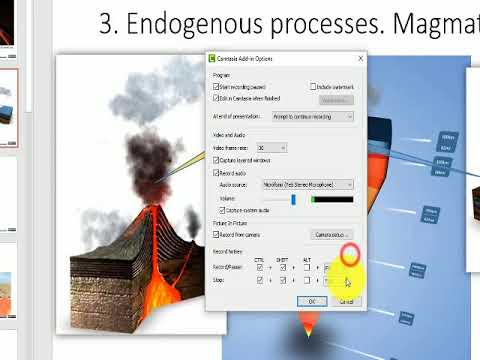

In [3]:
# CELL 13
import numpy as np
import cv2
import pickle

PARAM_TRAIN_SIZE  = 7000  # use first 7000 frames for training
PARAM_WINDOW_SIZE = 3
PARAM_ACTION      = "save" # one of "execute", "embed" or "save"

result = None
if PARAM_ACTION == "embed":
    from IPython.lib.display import YouTubeVideo
    result = YouTubeVideo('cPPjIFmAguQ')
else: 
    with open("ch10_cell12_model.pk", "rb") as pkl:
        clf = pickle.load(pkl)
        
    keyframes = set(map(lambda x:int(x.strip()), open("keyframes_by_hand.txt").readlines()))

    if PARAM_ACTION == "save":
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter('ch10_cell13_key_frames.avi',fourcc, 20.0, (640,480))

    cap = cv2.VideoCapture('video.mp4')
    previous_hists = [ None, ] * PARAM_WINDOW_SIZE
    frame_counter = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        hists = list()
        for idx in range(3):
            hist = cv2.calcHist([frame],[idx],None,[16],[0,256])
            hists.extend(hist.reshape(-1))
        to_show = False
        if previous_hists[0] is not None:
            pred = clf.predict( [ previous_hists[0] + hists ] )
            if pred[0] == 1.0:
                to_show = True
                frame[:,1:100,0] = 255
                frame[:,1:100,1] = 128
        previous_hists.pop(0)
        previous_hists.append(hists)

        if frame_counter in keyframes:
            to_show = True
            frame[:,200:300,1] = 255
            frame[:,200:300,0] = 128

        if frame_counter > PARAM_TRAIN_SIZE:
            frame[1:100,:,2] = 255
            frame[1:100,:,1] = 128
            
        if PARAM_ACTION == "save":
            frame = cv2.resize(frame,(640, 480), interpolation=cv2.INTER_CUBIC)
            out.write(frame)
            if to_show:
                for _ in range(10):
                    out.write(frame)
        else:
            cv2.imshow('frame', frame)
            delay = 6
            if to_show:
                delay = 600
            key = cv2.waitKey(delay) & 0xff
            if key == 27:
                break
        frame_counter += 1
        
    if PARAM_ACTION == "save":
        out.release()
    else:
        cv2.destroyAllWindows()
    cap.release()
    
result

That concludes key frames, let's move to blob tracking. First we need to identify the cursor region.

## Mean Shift

Let us start by running the full backprojection on each frame (Cell #14).

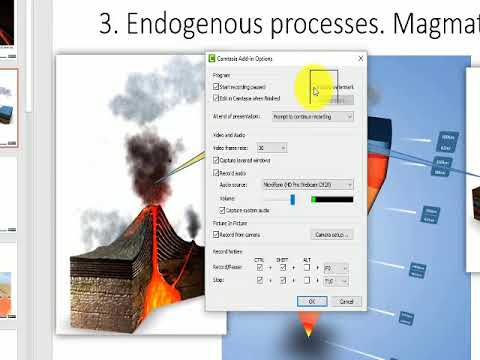

In [5]:
# CELL 14
import math
import time
import numpy as np
import cv2
from sklearn.cluster import KMeans

PARAM_ACTION = "save" # one of "execute", "embed", "time" or "save"

result = None
if PARAM_ACTION == "embed":
    from IPython.lib.display import YouTubeVideo
    result = YouTubeVideo('Dq_JWMc3ZV0')
else:
    mouse = cv2.imread('mouse_cursor_highlight.png')
    mouse = mouse[20:100,20:100]
    hsv_mouse = cv2.cvtColor(mouse,cv2.COLOR_BGR2HSV)
    mouse_hist = cv2.calcHist([hsv_mouse],[0, 1], None, [180, 256], [0, 180, 0, 256] )
    cv2.normalize(mouse_hist, mouse_hist, 0, 255, cv2.NORM_MINMAX)

    cap = cv2.VideoCapture('video.mp4')
    
    if PARAM_ACTION == "save":
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter('ch10_cell14_back_projection.avi',fourcc, 20.0, (640,480))

    start = time.time()
    frame_counter = 0
    box_counter = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_counter += 1
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        back_proj = cv2.calcBackProject([hsv_frame], [0,1], mouse_hist, [0,180,0,256], 1)

        # dilate
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
        cv2.filter2D(back_proj, -1, disc,back_proj)
        ret, thresholded = cv2.threshold(back_proj, 50, 255,0)

        nonzero = np.nonzero(thresholded)

        if len(nonzero[0]) > 0:
            # find most popular clump of points
            if len(nonzero[0]) > 1:
                kmeans = KMeans(n_clusters=2, random_state=1).fit(np.transpose(nonzero))
                centre = tuple(map(int, kmeans.cluster_centers_[0]))
                if kmeans.n_clusters == 2:
                    dist = math.sqrt(((kmeans.cluster_centers_[0] - kmeans.cluster_centers_[1])**2).sum())
                    if dist > 100: # don't sweat small differences
                        counts = { l: 0 for l in range(kmeans.n_clusters) }
                        for l in kmeans.labels_:
                            counts[l] += 1
                        if counts[1] > counts[0]:
                            centre = tuple(map(int,kmeans.cluster_centers_[1]))
            else:
                centre = (nonzero[0][0], nonzero[1][0])
            box_counter += 1
            # draw a box
            if PARAM_ACTION != "time":
                lower_x = max(0, centre[0] - 50)
                lower_y = max(0, centre[1] - 50)
                upper_x = min(frame.shape[0] - 1, centre[0] + 50)
                upper_y = min(frame.shape[1] - 1, centre[1] + 50)
                frame[lower_x:upper_x,lower_y] = [0,0,0]
                frame[lower_x:upper_x,upper_y] = [0,0,0]
                frame[lower_x,lower_y:upper_y] = [0,0,0]
                frame[upper_x,lower_y:upper_y] = [0,0,0]
        if PARAM_ACTION != "time":
            if PARAM_ACTION == "save":
                frame = cv2.resize(frame,(640, 480), interpolation=cv2.INTER_CUBIC)
                out.write(frame)
            else:
                cv2.imshow('back projection', frame)
                key = cv2.waitKey(60) & 0xff
                if key == 27:
                    break
    if PARAM_ACTION == "time":
        print("Processing took: {:,}, found {:,} boxes on {:,} frames".format(
            time.time() - start, box_counter, frame_counter))
    elif PARAM_ACTION == "save":
        out.release()
    else:
        cv2.destroyAllWindows()
    cap.release()
hsv_frame   = None
thresholded = None
back_proj   = None
result

That worked, with some errors but it was very slow, it took 785.76 seconds and found 5,291 boxes on 9,276 frames. Let us see to make it faster with MeanShift (Cell #15).

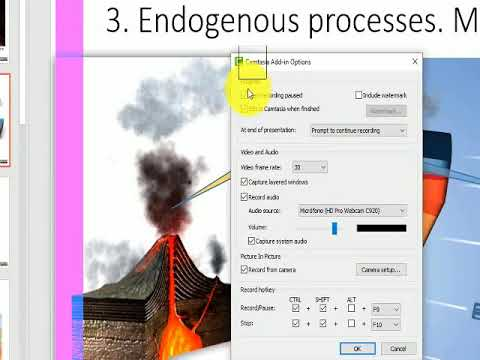

In [7]:
# CELL 15
import math
import time
import numpy as np
import cv2
from sklearn.cluster import KMeans

PARAM_ACTION = "save" # one of "execute", "embed", "time" or "save"

result = None
if PARAM_ACTION == "embed":
    from IPython.lib.display import YouTubeVideo
    result = YouTubeVideo('3gFNN2FYCqI')
else:
    mouse = cv2.imread('mouse_cursor_highlight.png')
    mouse = mouse[20:100,20:100]
    hsv_mouse = cv2.cvtColor(mouse,cv2.COLOR_BGR2HSV)
    mouse_hist = cv2.calcHist([hsv_mouse],[0, 1], None, [180, 256], [0, 180, 0, 256] )
    cv2.normalize(mouse_hist, mouse_hist, 0, 255, cv2.NORM_MINMAX)

    cap = cv2.VideoCapture('video.mp4')
    
    if PARAM_ACTION == "save":
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter('ch10_cell15_mean_shift.avi',fourcc, 20.0, (640,480))

    # ten iterations or move by at least 2 points
    ms_termination_criteria = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 1 )

    start = time.time()
    track_window = None
    frame_counter = 0
    box_counter = 0
    mean_shift_counter = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_counter += 1
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        back_proj = cv2.calcBackProject([hsv_frame], [0,1], mouse_hist, [0,180,0,256], 1)
        
        # dilate
        disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
        cv2.filter2D(back_proj, -1, disc,back_proj)
        ret, thresholded = cv2.threshold(back_proj, 50, 255,0)
        nonzero = np.nonzero(thresholded)
        
        ran_mean_shift = False
        if len(nonzero[0]) > 0:
            if track_window is not None:
                ran_mean_shift = True
                ret, track_window = cv2.meanShift(back_proj, track_window, ms_termination_criteria)
                #if not ret:
                #    track_window = None
            else:
                if len(nonzero[0]) > 1:
                    # find most popular clump of points
                    kmeans = KMeans(n_clusters=2, random_state=1).fit(np.transpose(nonzero))
                    centre = tuple(map(int, kmeans.cluster_centers_[0]))
                    if kmeans.n_clusters == 2:
                        dist = math.sqrt(((kmeans.cluster_centers_[0] - kmeans.cluster_centers_[1])**2).sum())
                        if dist > 100: # don't sweat small differences
                            counts = { l: 0 for l in range(kmeans.n_clusters) }
                            for l in kmeans.labels_:
                                counts[l] += 1
                            if counts[1] > counts[0]:
                                centre = tuple(map(int,kmeans.cluster_centers_[1]))
                else:
                    centre = (nonzero[0][0], nonzero[1][0])
            lower_x = max(0, centre[0] - 50)
            lower_y = max(0, centre[1] - 50)
            upper_x = min(frame.shape[0] - 1, centre[0] + 50)
            upper_y = min(frame.shape[1] - 1, centre[1] + 50)
            track_window = (lower_x, lower_y, upper_x - lower_x, upper_y - lower_y)
        else:
            track_window = None
                            
        if track_window is not None:
            box_counter += 1
            if ran_mean_shift:
                mean_shift_counter += 1
                
        if PARAM_ACTION != "time":
            if track_window is not None:
                if ran_mean_shift:
                    frame[:,200:300,1] = 255
                    frame[:,200:300,0] = 128
                else:
                    frame[:,200:300,1] = 128
                    frame[:,200:300,0] = 255

                # draw a box
                frame[track_window[0]:track_window[0]+track_window[2],track_window[1]] = [0,0,0]
                frame[track_window[0]:track_window[0]+track_window[2],track_window[1]+track_window[3]] = [0,0,0]
                frame[track_window[0],track_window[1]:track_window[1]+track_window[3]] = [0,0,0]
                frame[track_window[0]+track_window[2],track_window[1]:track_window[1]+track_window[3]] = [0,0,0]
            else:
                frame[1:100,:,2] = 255
                frame[1:100,:,1] = 128
        if PARAM_ACTION != "time":
            if PARAM_ACTION == "save":
                frame = cv2.resize(frame,(640, 480), interpolation=cv2.INTER_CUBIC)
                out.write(frame)
                if track_window is not None and not ran_mean_shift:
                    for _ in range(10):
                        out.write(frame)
            else:
                cv2.imshow('back projection', frame)
                delay = 60
                if track_window is not None and not ran_mean_shift:
                    delay = 600
                key = cv2.waitKey(delay) & 0xff
                if key == 27:
                    break
    if PARAM_ACTION == "time":
        print("Processing took: {:,}, found {:,} boxes on {:,} frames ({:,} using mean shift)".format(
            time.time() - start, box_counter, frame_counter, mean_shift_counter))
    elif PARAM_ACTION == "save":
        out.release()
    else:
        cv2.destroyAllWindows()
    cap.release()
hsv_frame   = None
thresholded = None
back_proj   = None
result

That took 680.80s, almost 100s less than the original algorithm and it found the same number of boxes, with 4,886 (92% of the total) found by meanshift. The execution shows places where meanshift got lost, though. It would be worth tuning its parameters better.

# Geographical Features

In GIS features, we would look at using representions based on distance to key points. 

## Example Data

We will be using the migration data through satellite telemetry for African cuckoos in Nigeria, kindly released by [Iwajomo SB et al, 2018 as part of the movebank.org data repository](https://www.datarepository.movebank.org/handle/10255/move.714). It contains 12,563 tracking points for six individuals, from May 29th, 2013 until Jun 28th, 2017.

We will look into the problem of predicting whether a bird will move in the next two hours.

In [9]:
# CELL 21
rows = list()
with open("African cuckoo in Nigeria (data from Iwajomo et al. 2018).csv") as csv:
    header = None
    for row in csv:
        cols = row.split(",")
        if header is None:
            header = { w: i for i, w in enumerate(cols) }
        else:
            long =  cols[header['location-long']]
            lat = cols[header['location-lat']]
            if len(long) > 3 and len(lat) > 3:
                rows.append( [ 
                    cols[header['timestamp']],
                    long,
                    lat,
                    cols[header['individual-local-identifier']]
                ])
print("Read", len(rows), "rows")

Read 12096 rows


We will now split the rows by individual, leaving two individuals for training, two for devtest and one for final testing.

To obtain the classes (moved or not), we parse the time stamps and assign a class depending on the number of seconds between two entries. We will also explode the date and time as individual features and compute a "day in the year" feature.

In [10]:
# CELL 22
import random

individuals = set(map(lambda x:x[-1], rows))

print("Total individuals:", len(individuals))

for indiv in individuals:
    print(indiv, len(list(filter(lambda x:x[-1] == indiv, rows))))

random_indiv = list(individuals)
random.shuffle(random_indiv, random=random.Random(40).random)
train_indiv = set(random_indiv[0:2])
test_indiv  = set(random_indiv[2:4])
final_test_indiv = set(random_indiv[4])

train_rows = len(list(filter(lambda x:x[-1] in train_indiv, rows)))
print("Total train rows:", train_rows)
test_rows  = len(list(filter(lambda x:x[-1] in test_indiv, rows)))
print("Total test rows:", test_rows)

Total individuals: 5
"126695" 136
"126698" 712
"126697" 3063
"126694" 4568
"126696" 3617
Total train rows: 4329
Total test rows: 4704


In [11]:
# CELL 23
import re
import datetime
import numpy as np

xtrain = np.zeros((train_rows, 
                   3 + # year, month, day 
                   1 + # day of year
                   3 + # hh, mm, ss
                   2 # lat long
                  ), dtype='float32')
ytrain = np.zeros((train_rows,), dtype='float32')

prev = None
for idx, row in enumerate(filter(lambda x:x[-1] in train_indiv, rows)):
    year, month, day, hh, mm, ss = re.split(" |-|:+", row[0])
    year = int(year)
    month = int(month)
    day = int(day)
    hh = int(hh)
    mm = int(hh)
    ss = float(ss)
    dt = datetime.datetime(year, month, day, hh, mm, int(ss))
    try:
        xtrain[idx,:] = [ 
            year, month, day, dt.timetuple().tm_yday, hh, mm, ss,
            float(row[1]), float(row[2])
        ]
    except:
        print(row)
    ts = dt.timestamp()
    if prev is None:
        ytrain[idx] = 0.0
    else:
        if ts - prev > 2 * 60 * 60:
            ytrain[idx] = 1.0
        else:
            ytrain[idx] = 0.0
    prev = ts 
print(np.sum(ytrain))

xtest = np.zeros((test_rows, xtrain.shape[1]), dtype='float32')
ytest = np.zeros((test_rows,), dtype='float32')

prev = None
for idx, row in enumerate(filter(lambda x:x[-1] in test_indiv, rows)):
    year, month, day, hh, mm, ss = re.split(" |-|:+", row[0])
    year  = int(year)
    month = int(month)
    day   = int(day)
    hh    = int(hh)
    mm    = int(hh)
    ss    = float(ss)
    dt    = datetime.datetime(year, month, day, hh, mm, int(ss))
    try:
        xtest[idx,:] = [ 
            year, month, day, dt.timetuple().tm_yday, hh, mm, ss,
            float(row[1]), float(row[2])
        ]
    except:
        print(row)
    ts = dt.timestamp()
    if prev is None:
        ytest[idx] = 0.0
    else:
        if ts - prev > 2 * 60 * 60:
            ytest[idx] = 1.0
        else:
            ytest[idx] = 0.0
    prev = ts 

print(np.sum(ytest))

1571.0
1727.0


In [12]:
# CELL 24
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

rf = RandomForestClassifier(n_estimators = 100, random_state=42)

print("Training on {:,} instances for {:,} features".format(*xtrain.shape))
rf.fit(xtrain, ytrain)
ytest_pred = rf.predict(xtest)

prec, rec, f1, _ = precision_recall_fscore_support(ytest, ytest_pred)

print("[Base] Prec ", prec, "Rec", rec, "F1", f1)

Training on 4,329 instances for 9 features
[Base] Prec  [0.74148211 0.475382  ] Rec [0.58481693 0.64852345] F1 [0.65389671 0.54861621]


## Radial distance

We will use a list of administrative units obtained from [GeoNames.org](http://download.geonames.org/export/dump/) for both Nigeria and Cameroon and add features as the distance to each of these points.

In [13]:
# CELL 25
import geopy.distance

adms = list() # of coordinate tuples

with open("NG.txt") as cm:
    for line in cm:
        fields = line.split("\t")
        if fields[7] == 'ADM2':
            adms.append( (fields[1], (float(fields[4]), float(fields[5]))) )
with open("CM.txt") as cm:
    for line in cm:
        fields = line.split("\t")
        if fields[7] == 'ADM2':
            adms.append( (fields[1], (float(fields[4]), float(fields[5]))) )

# center for points
lat_center, lon_center = xtrain[:,-2].mean(), xtrain[:,-1].mean()
            
print("Total cities:", len(adms))

close_cities = list()
for adm_coord in adms:
    dist = geopy.distance.distance( (lat_center, lon_center), adm_coord[1])
    if dist.km < 50:
        close_cities.append(adm_coord[1])
        print(adm_coord[0], dist)
print("Close cities:", len(close_cities))

Total cities: 850
Bogoro 35.84774684912604 km
Pankshin 32.873642543060335 km
Kanke 8.261085165141486 km
Langtang North 34.43641345609853 km
Mikang 36.578234698663614 km
Close cities: 5


In [14]:
# CELL 25
import geopy.distance

xtrain_radial = np.zeros((xtrain.shape[0], xtrain.shape[1] + len(close_cities)), dtype='float32')
xtrain_radial[:,:xtrain.shape[1]] = xtrain

for row_idx in range(xtrain.shape[0]):
    for idx, adm_coord in enumerate(close_cities):
        xtrain_radial[row_idx][xtrain.shape[1] + idx] = \
          geopy.distance.distance((xtrain[row_idx][-2], xtrain[row_idx][-1]), adm_coord).km

xtest_radial = np.zeros((xtest.shape[0], xtest.shape[1] + len(close_cities)), dtype='float32')
xtest_radial[:,:xtest.shape[1]] = xtest

for row_idx in range(xtest.shape[0]):
    for idx, adm_coord in enumerate(close_cities):
        xtest_radial[row_idx][xtest.shape[1] + idx] = \
          geopy.distance.distance((xtest[row_idx][-2], xtest[row_idx][-1]), adm_coord).km

print("Training on {:,} instances for {:,} features".format(*xtrain_radial.shape))
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(xtrain_radial, ytrain)
ytest_pred_radial = rf.predict(xtest_radial)

prec, rec, f1, _ = precision_recall_fscore_support(ytest, ytest_pred_radial)

print("[Radial] Prec ", prec, "Rec", rec, "F1", f1)

Training on 4,329 instances for 14 features
[Radial] Prec  [0.72727273 0.47908922] Rec [0.62344642 0.596989  ] F1 [0.67136914 0.5315803 ]


# Preferences

Let's transform the git data into pseudo-preferences by normalizing by comitter and dropping entries less than 0.1%

Also compute the target variable (Mean-Reciprocal-Rank for monthly file importance). Cell #31.

In [15]:
# CELL 31
import time

PARAM_DATA_FOLDER="./gitreco"

files = list(map(lambda x:x.strip(),open("{}/files.txt".format(PARAM_DATA_FOLDER)).readlines()))
print("Found {:,} files".format(len(files)))

def date2month(date_):
    gm = time.gmtime(date_)
    return "{}-{:02}".format(gm.tm_year, gm.tm_mon)

# first pass, get all the available months
print("First pass")
all_months = set()
with open("{}/file-dates.tsv".format(PARAM_DATA_FOLDER)) as f:
    line_no = 0
    for line in f:
        if line_no % (len(files) // 10) == 0:
            print("{:,} out of {:,} read".format(line_no, len(files)))
        fields = list(map(int, line.strip().split("\t")))
        _      = fields.pop(0)
        all_months.update(map(date2month, fields))
        line_no += 1
print("Read dates")

months            = sorted(list(all_months))
month_to_month_id = dict(map(lambda x: (x[1], x[0]),enumerate(months)))
files_per_month   = { month: dict() for month in months }
print("Data for", len(months), "months")

commit_dates = dict()
file_range   = dict()
print("Second pass")
with open("{}/file-dates.tsv".format(PARAM_DATA_FOLDER)) as f:
    line_no = 0
    for line in f:
        if line_no % (len(files) // 10) == 0:
            print("{:,} out of {:,} read".format(line_no, len(files)))
        fields  = list(map(int, line.strip().split("\t")))
        file_id = fields.pop(0)
        start   = None
        end     = None
        for month in map(date2month, fields):
            if start is None:
                start = month
            elif start > month:
                start = month
            if end   is None:
                end   = month
            elif end   < month:
                end   = month
            
            files_per_month[month][file_id] = 1 + files_per_month[month].get(file_id, 0)
        line_no += 1
        file_range[file_id] = (start, end)
print("Read dates")

# ranks per month
ranks_per_month = dict()
for month in files_per_month.keys():
    pairs = sorted(files_per_month[month].items(), key=lambda x:-x[1])
    ranks = dict()
    current_rank = 0
    previous = -1
    for file_id, commits in pairs:
        if files[file_id] == "/dev/null":
            continue # skip artifact in the data
        if commits != previous:
            previous = commits
            current_rank += 1
        ranks[file_id] = current_rank
    ranks_per_month[month] = ranks
print("Months ranked")

# mean reciprocal rank
file_mrr = dict()
for file_id in file_range.keys():
    start, end    = file_range[file_id]
    started       = False
    rr_accum      = 0
    month_counter = 0
    for month in months:
        if not started and month != start:
            continue
        started = True
        month_counter += 1
        
        if file_id in ranks_per_month[month]:
            rr_accum += 1.0 / ranks_per_month[month][file_id]
        
        if month == end:
            break
    if month_counter > 10:
        file_mrr[file_id] = rr_accum / month_counter
print("MRRs computed")

with open("ch10_cell31_mrrs.tsv", "w") as f:
    f.write("file_id\tfile\tmrr\n")
    for file_id, file in enumerate(files):
        if file_id in file_mrr:
            f.write("{}\t{}\t{:1.8}\n".format(file_id, file, file_mrr[file_id]))
file_mrr = None
files    = None

Found 95,571 files
First pass
0 out of 95,571 read
9,557 out of 95,571 read
19,114 out of 95,571 read
28,671 out of 95,571 read
38,228 out of 95,571 read
47,785 out of 95,571 read
57,342 out of 95,571 read
66,899 out of 95,571 read
76,456 out of 95,571 read
86,013 out of 95,571 read
95,570 out of 95,571 read
Read dates
Data for 134 months
Second pass
0 out of 95,571 read
9,557 out of 95,571 read
19,114 out of 95,571 read
28,671 out of 95,571 read
38,228 out of 95,571 read
47,785 out of 95,571 read
57,342 out of 95,571 read
66,899 out of 95,571 read
76,456 out of 95,571 read
86,013 out of 95,571 read
95,570 out of 95,571 read
Read dates
Months ranked
MRRs computed


Let us see how those MRRs look like and see if they make sense (Cell #32).

In [16]:
# CELL 32
file_mrr = dict()
files    = dict()
with open("ch10_cell31_mrrs.tsv") as f:
    next(f)
    for line in f:
        file_id, file, mrr = line.split('\t')
        file_id            = int(file_id)
        mrr                = float(mrr)
        file_mrr[file_id]  = mrr
        files[file_id]     = file

print("Total files with MRR", len(file_mrr),"\n")
for file_id, mrr in sorted(file_mrr.items(), key=lambda x:-x[1])[:50]:
    print(files[file_id], mrr)
file_mrr = None
files    = None

Total files with MRR 81494 

MAINTAINERS 0.91181878
drivers/scsi/libata-core.c 0.31163823
Makefile 0.27082308
kernel/sched.c 0.13061257
net/core/dev.c 0.10050353
sound/pci/hda/patch_realtek.c 0.095225337
drivers/gpu/drm/i915/intel_display.c 0.090184201
drivers/scsi/libata-scsi.c 0.076660623
drivers/net/wireless/iwlwifi/iwl4965-base.c 0.066584964
drivers/net/tg3.c 0.064789696
Documentation/kernel-parameters.txt 0.060356971
kernel/perf_event.c 0.058511001
drivers/net/ethernet/renesas/ravb_main.c 0.055951445
drivers/net/ixgbe/ixgbe_main.c 0.055288359
drivers/net/vxlan.c 0.053370087
drivers/kvm/kvm_main.c 0.050630128
drivers/net/wireless/ath9k/main.c 0.049333291
drivers/net/wireless/bcm43xx/bcm43xx_main.c 0.048814943
drivers/gpu/drm/amd/amdgpu/amdgpu.h 0.048078596
drivers/net/sky2.c 0.047818016
drivers/net/ethernet/broadcom/bnx2x/bnx2x_main.c 0.047805524
block/ll_rw_blk.c 0.047304502
kernel/perf_counter.c 0.047084825
drivers/ata/libata-core.c 0.045208759
drivers/scsi/sata_mv.c 0.044798209


Let us now normalize the committers preferences (Cell #33).

In [17]:
# CELL 33
import numpy as np
from collections import OrderedDict

PARAM_DATA_FOLDER="./gitreco"

file_mrr = OrderedDict()
files    = dict()
with open("ch10_cell31_mrrs.tsv") as f:
    next(f)
    for line in f:
        file_id, file, mrr = line.split('\t')
        file_id            = int(file_id)
        mrr                = float(mrr)
        file_mrr[file_id]  = mrr
        files[file_id]     = file
print("MRRs for {:,} files".format(len(file_mrr)))
committers = list()
with open("{}/authors.txt".format(PARAM_DATA_FOLDER)) as f:
    committers = list(map(lambda x:x.strip(), f.readlines()))
print("Total {:,} committers".format(len(committers)))
    
file_id_to_row = dict( map(lambda x: (x[1], x[0]), enumerate(file_mrr.keys())) )

preferences = np.zeros( (len(files), len(committers)), dtype='float32' )
print("Preferences {:,}x{:,} total {:,} cells"
      .format(preferences.shape[0],preferences.shape[1],preferences.shape[0]*preferences.shape[1]))

# read counts
counter = 0
with open("{}/counts.tsv".format(PARAM_DATA_FOLDER)) as f:
    for line in f:
        fields = line.split('\t')
        if fields[0] == '':
            file_id = int(fields[1])
            if file_id in file_id_to_row:
                counter += 1
                counts   = int(fields[2])
                preferences[file_id_to_row[file_id], committer_id] = counts
        else:
            committer_id = int(fields[0])
print("Read {:,} counts".format(counter))

# save unnormalized
np.savez_compressed("ch10_cell33_preferences_raw.npz",
                    preferences=preferences)

# normalize per committer
print("Normalizing")
totals    = preferences.sum(axis=0)
zero_cols = list(map(lambda x:x[0], filter(lambda x:x[1], enumerate(totals == 0))))
print("Filtering ", len(zero_cols), " zero columns")
for col in reversed(zero_cols):
    preferences = np.delete(preferences, col, axis = 1)
    totals      = np.delete(totals, col)
    del committers[col]
with open("ch10_cell33_filtered_committers.txt", "w") as f:
    f.write("\n".join(committers) + "\n")
preferences = preferences / totals[None,:]
preferences[preferences < 0.00001] = 0.0
print("Saving")
np.savez_compressed("ch10_cell33_preferences.npz",
                    preferences=preferences)
preferences    = None
file_mrr       = None
files          = None
file_id_to_row = None

MRRs for 81,494 files
Total 15,427 committers
Preferences 81,494x15,427 total 1,257,207,938 cells
Read 68,679,582 counts
Normalizing
Filtering  63  zero columns
Saving


From here, we can extract the raw data (Cell #34).

In [18]:
# CELL 34
import numpy as np
from collections import OrderedDict

PARAM_DATA_FOLDER="./gitreco"

preferences = None
preferences = np.load("ch10_cell33_preferences.npz")['preferences']

committers = list(map(lambda x:x.strip(), open("ch10_cell33_filtered_committers.txt").readlines()))

file_mrr = OrderedDict()
files    = dict()
with open("ch10_cell31_mrrs.tsv") as f:
    next(f)
    for line in f:
        file_id, file, mrr = line.split('\t')
        file_id            = int(file_id)
        mrr                = float(mrr)
        file_mrr[file_id]  = mrr
        files[file_id]     = file
file_id_to_row = dict( map(lambda x: (x[1], x[0]), enumerate(file_mrr.keys())) )

file_features = dict()
with open("{}/file-features.tsv".format(PARAM_DATA_FOLDER)) as f:
    for line in f:
        fields                 = list(map(lambda x:int(float(x)), line.strip().split("\t")))
        file_id                = fields.pop(0)
        file_features[file_id] = fields

with open("ch10_cell34_raw_data.tsv", "w") as f:
    f.write("file_name\tfile_id\tlength\tincludes\tstructs")
    for ch in range(256):
        f.write("\tchar-" + str(ch))
    for committer in committers:
        f.write("\t"      + committer)
    f.write("\tMRR\n")
    for file_id, row in file_id_to_row.items():
        f.write(files[file_id] + "\t" + str(file_id))
        f.write("\t"           + "\t".join(map(str, file_features[file_id])))
        f.write("\t"           + "\t".join(map(str, preferences[row,:])))
        f.write("\t"           + str(file_mrr[file_id]) + "\n")
print("Saved")
preferences    = None
file_features  = None
file_id_to_row = None
files          = None
file_mrr       = None

Saved


Splitting into train and final test (Cell #35).

In [19]:
# CELL 35
import random

rand = random.Random(42)
with open("ch10_cell34_raw_data.tsv") as f:
    header = next(f)
    with open("ch10_cell35_raw_data_train.tsv", "w") as tr:
        tr.write(header)
        with open("ch10_cell35_raw_data_test.tsv", "w") as te:
            te.write(header)
            for line in f:
                if rand.random() < 0.2:
                    te.write(line)
                else:
                    tr.write(line)

Now extracting text features from the name and training a RFR (Cell #36).

In [20]:
# CELL 36
import random
import re
import math
import time
import numpy as np

TOK_PATTERN = re.compile("[^a-zA-Z0-9]")

train_data = list()
test_data  = list()
header = None
rand   = random.Random(42)
with open("ch10_cell35_raw_data_train.tsv") as f:
    header = next(f)
    header = header.strip().split("\t")
    del header[1] # file_id
    for line in f:
        fields = line.strip().split("\t")
        del fields[1] # file_id
        if len(fields) != len(header):
            continue
        fname  = fields.pop(0)
        fields = list(map(lambda x: 0 if x== "" else float(x), fields))
        mrr    = fields.pop()
        row    = ( np.array( fields ), mrr, fname)
        if rand.random() < 0.2:
            test_data.append( row )
        else:
            train_data.append( row )
print("Read", len(train_data) + len(test_data), "rows")

def base_tokenize(fname):
    return re.split(TOK_PATTERN, fname)

# determine vocabulary on train data only
vocab = dict()
for _, _, fname in train_data:
    for tok in base_tokenize(fname):
        vocab[tok] = vocab.get(tok, 0) + 1
vocab = list(map(lambda x:x[0], filter(lambda x:x[1] >= 1000, vocab.items())))
vocab_to_pos = dict(map(lambda x: (x[1], x[0]), enumerate(vocab)))
print("Found", len(vocab), "tokens")
base_len = len(train_data[0][0])
xtrain = np.zeros( (len(train_data), base_len + len(vocab) + 1) )
ytrain = np.zeros( (len(train_data),) )
xtest  = np.zeros( (len(test_data),  base_len + len(vocab) + 1) )
ytest  = np.zeros( (len(test_data), ) )

for idx, row in enumerate(train_data):
    feats, mrr, fname = row
    toks              = base_tokenize(fname)
    xtrain[idx,:base_len] = feats
    xtrain[idx,base_len]  = len(fname.split("/"))
    for tok in set(toks):
        if tok in vocab_to_pos:
            xtrain[idx, base_len + 1 + vocab_to_pos[tok]] = 1.0
    ytrain[idx] = mrr
for idx, row in enumerate(test_data):
    feats, mrr, fname = row
    toks              = base_tokenize(fname)
    xtest[idx,:base_len] = feats
    xtest[idx,base_len]  = len(fname.split("/"))
    for tok in set(toks):
        if tok in vocab_to_pos:
            xtest[idx, base_len + 1 + vocab_to_pos[tok]] = 1.0
    ytest[idx] = mrr

# save features
with open("ch10_cell36_pref_feats.tsv", "w") as f:
    f.write("\t".join(header[1:-1]) + "\tpath_component")
    for tok in vocab:
        f.write('\ttok-' + tok)
    f.write('\tMRR\n')
    for idx in range(xtrain.shape[0]):
        f.write("\t".join(map(str, xtrain[idx,:])) + "\t" + str(ytrain[idx]) + "\n")
    for idx in range(xtest.shape[0]):
        f.write("\t".join(map(str, xtest[idx,:]))  + "\t" + str(ytest[idx]) + "\n")

np.savez_compressed("ch10_cell36_train.npz",
                    xtrain=xtrain, ytrain=ytrain,
                    xtest=xtest,   ytest=ytest)
print("Train data saved.")

# train RFR
from sklearn.ensemble import RandomForestRegressor

print("Training on {:,} instances with {:,} features".format(*xtrain.shape))
start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain, ytrain)
print("Training took {:,} seconds".format(time.time() - start))

ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest-ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

rfr        = None
train_data = None
test_data  = None
xtrain     = None
xtest      = None
ytrain     = None

Read 65038 rows
Found 37 tokens
Train data saved.
Training on 51,975 instances with 15,661 features
Training took 7,606.067658424377 seconds
RMSE 0.0010141584472770557


To compute preferences, we start by computing the Tanimoto similarity between each committer (Cell #37).

In [21]:
# CELL 37
import numpy as np
import time
import os

PARAM_MULTIPROC = True # set only to true on POSIX systems

loaded = np.load("ch10_cell36_train.npz")
xtrain = loaded['xtrain']
ytrain = loaded['ytrain']
xtest  = loaded['xtest'] 
ytest  = loaded['ytest']

pstart = 259
pend   = 15623


# transform to boolean preferences
boolean_prefs = np.zeros( (xtrain.shape[0], pend - pstart), dtype='uint8' )
boolean_prefs[ xtrain[:,pstart:pend] > 0 ] = 1
print("Boolean preferences computed")

data_array = None

def handle_job(c1): # compute Tanimoto multiproc
    boolean_prefs = data_array['boolean_prefs']
    pid = os.getpid()
    start = time.time()
    with open("ch10_cell37_tmp_"+str(pid)+".tanimoto.tsv", "a") as f:
        f.write("{}\t{}\t1.0\n".format(c1, c1))
        col1 = boolean_prefs[:, c1]
        sums = boolean_prefs[:,(c1+1):] + col1[:, None]
        mask = np.zeros( sums.shape, dtype='bool')
        mask[sums > 1] = 1
        inters = mask.sum(axis=0)
        mask[sums > 0] = 1
        unions = mask.sum(axis=0)
        for c2 in range(c1 + 1, boolean_prefs.shape[1]):
            union = unions[c2 - c1 - 1]
            if union > 0:
                iou = inters[c2 - c1 - 1] * 1.0 / union # intersection over union
            else:
                iou = 0.0
            f.write("{}\t{}\t{}\n".format(c1, c2, iou))
        if c1 % 1000 == 0:
            print("[{}], committer {:,} processed in {:,}".format(pid, c1, time.time() - start))
    return pid

# compute Tanimoto
if PARAM_MULTIPROC:
    import multiprocessing

    def launch_jobs(data, num_worker, num_jobs):
        global data_array
        data_array = data

        global pool 
        pool = multiprocessing.Pool(num_worker)
        return pool.map(handle_job, range(num_jobs))

    pids = launch_jobs({ 'boolean_prefs': boolean_prefs }, 4, pend - pstart - 1)
    pids = set(pids)

    tanimoto = np.zeros( (pend - pstart, pend - pstart) )
    for pid in pids:
        with open("ch10_cell37_tmp_"+str(pid)+".tanimoto.tsv") as f:
            for line in f:
                c1, c2, t = line.strip().split("\t")
                c1 = int(c1)
                c2 = int(c2)
                t = float(t)
                tanimoto[c1,c2] = tanimoto[c2, c1] = t
        print(pid, "read")
        
    #import signal
    #for pid in pids:
    #    os.kill(pid, signal.SIGTERM)
    pool.close()
    pool.join()
else:
    tanimoto = np.zeros( (pend - pstart, pend - pstart) )
    prev = time.time()
    for c1 in range(0, pend-pstart - 1):
        if c1 % ( (pend-pstart) // 10) == 0:
            print("Committer {:,} of {:,} processed in {:,}".format(c1, pend-pstart, time.time() - prev))
            prev = time.time()
        tanimoto[c1, c1] = 1.0
        col1 = boolean_prefs[:, c1]
        sums = boolean_prefs[:,(c1+1):] + col1[:, None]
        mask = np.zeros( sums.shape, dtype='bool')
        mask[sums > 1] = 1
        inters = mask.sum(axis=0)
        mask[sums > 0] = 1
        unions = mask.sum(axis=0)
        for c2 in range(c1 + 1, pend - pstart):
            union = unions[c2 - c1 - 1]
            if union > 0:
                iou = inters[c2 - c1 - 1] * 1.0 / union # intersection over union
            else:
                iou = 0.0
            tanimoto[c1, c2] = tanimoto[c2, c1] = iou

with open("ch10_cell37_tanimoto.tsv", "w") as f:
    for idx in range(tanimoto.shape[0]):
        f.write("\t".join(map(str,tanimoto[idx,:])) + "\n")
np.savez_compressed("ch10_cell37_tanimoto.npz", tanimoto=tanimoto)
boolean_prefs = None
tanimoto      = None
xtrain = None
xtest  = None

Boolean preferences computed
[7308], committer 0 processed in 20.112276315689087
[7309], committer 1,000 processed in 16.814667224884033
[7310], committer 2,000 processed in 14.553977012634277
[7311], committer 3,000 processed in 12.290720462799072
[7311], committer 4,000 processed in 6.025493860244751
[7310], committer 5,000 processed in 3.7796213626861572
[7309], committer 6,000 processed in 3.4389824867248535
[7308], committer 7,000 processed in 3.3005387783050537
[7308], committer 8,000 processed in 2.6892199516296387
[7309], committer 9,000 processed in 2.4650516510009766
[7311], committer 11,000 processed in 1.6634607315063477
[7310], committer 10,000 processed in 1.967383623123169
[7311], committer 12,000 processed in 1.2545585632324219
[7310], committer 13,000 processed in 0.8924024105072021
[7309], committer 14,000 processed in 0.5134038925170898
[7308], committer 15,000 processed in 0.12378334999084473
7308 read
7309 read
7310 read
7311 read


With the Tamimoto coefficient we can proceed to impute (Cell #38).

In [22]:
# CELL 38
import numpy as np
import math
import time

loaded = np.load("ch10_cell36_train.npz")
xtrain = loaded['xtrain']
ytrain = loaded['ytrain']
xtest =  loaded['xtest'] 
ytest =  loaded['ytest']
tanimoto = np.load("ch10_cell37_tanimoto.npz")['tanimoto']
    
with open("ch10_cell35_raw_data_train.tsv") as f:
    header = next(f)
    header = header.strip().split("\t")
    del header[1] # file_id

pstart = 259
pend   = 15623

def impute(row, table):
    # see how many entries we will impute and the imputation value
    non_zero   = np.count_nonzero(row)
    sorted_row = np.sort(row)
    median      = sorted_row[-(non_zero // 2)]
    imputed                      = np.dot(row, table)
    imputed[row > 0]             = 0.0 # mask existing ones
    sorted_imputed = np.sort(imputed)
    threshold      = sorted_imputed[-non_zero]
    imputed[imputed < threshold] = 0.0 # drop less strong recos
    imputed[imputed > 0]         = median # impute with median
    row += imputed # modify in place
    return row

# impute train set
print("Total cells: {:,}".format(xtrain.shape[0]*(pend - pstart)))
print("Non-empty cells: {:,}".format((xtrain[:,pstart:pend] > 0).sum()))

start = time.time()
for idx in range(xtrain.shape[0]):
    to_print = idx % ( xtrain.shape[0] // 10) == 0
    if to_print:
        start = time.time()
    impute(xtrain[idx,pstart:pend], tanimoto)
    if  to_print:
        print("Imputing train file row {:,} of {:,} (last row took {:,})".format(
            idx, xtrain.shape[0], time.time()-start))
    start = time.time()
    
for idx in range(xtest.shape[0]):
    if idx % ( xtest.shape[0] // 10) == 0:
        print("Imputing test file {:,} of {:,}".format(idx, xtest.shape[0]))
    impute(xtest[idx,pstart:pend], tanimoto)
    
# save imputed files
with open("ch10_cell38_pref_feats_imputed.tsv", "w") as f:
    f.write("\t".join(header) + "\n")
    for idx in range(xtrain.shape[0]):
        f.write("\t".join(map(str, xtrain[idx,:])) + "\t" + str(ytrain[idx]) + "\n")
    for idx in range(xtest.shape[0]):
        f.write("\t".join(map(str, xtest[idx,:]))  + "\t" + str(ytest[idx])  + "\n")

np.savez_compressed("ch10_cell38_train.npz",
                    xtrain=xtrain, ytrain=ytrain,
                    xtest=xtest,   ytest=ytest)
print("Train data saved.")
tanimoto = None

# train RFR
from sklearn.ensemble import RandomForestRegressor

print("Training on {:,} instances with {:,} features".format(*xtrain.shape))
start = time.time()
rfr = RandomForestRegressor(max_features=1.0, random_state=42, n_estimators=200, n_jobs=-1)
rfr.fit(xtrain, ytrain)
print("Training took {:,} seconds".format(time.time() - start))

ytest_pred = rfr.predict(xtest)
RMSE = math.sqrt(sum((ytest-ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

rfr        = None
train_data = None
test_data  = None
xtrain     = None 
xtest      = None

Total cells: 798,543,900
Non-empty cells: 36,520,460
Imputing train file row 0 of 51,975 (last row took 0.4574160575866699)
Imputing train file row 5,197 of 51,975 (last row took 0.2369997501373291)
Imputing train file row 10,394 of 51,975 (last row took 0.23708176612854004)
Imputing train file row 15,591 of 51,975 (last row took 0.23601460456848145)
Imputing train file row 20,788 of 51,975 (last row took 0.24098992347717285)
Imputing train file row 25,985 of 51,975 (last row took 0.23624229431152344)
Imputing train file row 31,182 of 51,975 (last row took 0.23597192764282227)
Imputing train file row 36,379 of 51,975 (last row took 0.23587584495544434)
Imputing train file row 41,576 of 51,975 (last row took 0.2358112335205078)
Imputing train file row 46,773 of 51,975 (last row took 0.23598027229309082)
Imputing train file row 51,970 of 51,975 (last row took 0.23586344718933105)
Imputing test file 0 of 13,063
Imputing test file 1,306 of 13,063
Imputing test file 2,612 of 13,063
Imputing

The final RMSE of 0.0008565839588158692 is better than the RMSE of 0.0010542858791082223

In [23]:
# memory check
import sys

l = list()
for v in dir():
    l.append( (int(eval("sys.getsizeof({})".format(v))), v) )
for c, v in sorted(l, reverse=True)[:20]:
    print("\t{:,}\t{}".format(c,v))

	5,242,984	file_range
	2,621,552	ranks
	491,616	pairs
	415,896	ytrain
	263,536	xtest_radial
	242,536	xtrain_radial
	184,432	mouse_hist
	133,352	header
	133,352	fields
	133,352	committers
	125,080	feats
	104,600	ytest_pred
	104,600	ytest
	98,632	rows
	77,856	data_y
	77,856	data_x
	63,120	shuffled
	61,552	totals
	56,096	ytrain_pred
	23,296	ytrain_sampled
